In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
#!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import pandas as pd
import logging
import gensim
from scipy import spatial

orginal_sentences_oath_file = 'Data/Hebrew/SVLM_Hebrew_Wikipedia_Corpus.txt'
tagged_sentences_path_file = 'Data/Hebrew/parsed.txt'
csv_hebrew_sentences_path_file = 'Data/Hebrew/Hebrew_tagged_sentences.csv'
NUM_EXAMPLES = 50000
EMBEDDING_DIM = 300

In [2]:
#extract subject for each tagged sentence
def extract_sbj(sentences):
    listoflists = []
    sublist = []
    for i in sentences:
        if i.find("SBJ") !=-1:
            i = re.sub(r"[^א-ת\"]+", " ", i)
            if len(i)>3:
                sublist.append(i)
        elif i == '\n':
            listoflists.append(sublist)
            sublist = []
    return listoflists

#flat the list of subject to one string
def listToString(s):  
    str1 = " " 
    return (str1.join(s))

#match subject to orginal sentence
def make_pairs(orginal_sentences,tagged_sentences,num_examples):
    subjects = extract_sbj(tagged_sentences)
    clear_lines = []
    for tag, sentence in zip(subjects[:num_examples],orginal_sentences[:num_examples]):
        clear_lines.append(listToString(tag) + '\t' + sentence)
    subject = []
    sentences = []
    for line in clear_lines:
        line = line.split('\t')
        sentences.append(line[1])
        subject.append(line[0])
    return subject, sentences

def make_csv_subject_sentence(orginal_sentences,tagged_sentences, csv_path,num_examples):
    subjects, sentences = make_pairs(orginal_sentences,tagged_sentences,num_examples)
    trainDF = pd.DataFrame()
    trainDF['subject'] = subjects[:num_examples]
    trainDF['sentence'] = sentences[:num_examples]
    mask = (trainDF['subject'].str.len()>1)
    trainDF = trainDF.loc[mask]
    trainDF.to_csv(csv_path)

In [3]:
orginal_sentences = open(orginal_sentences_oath_file).readlines()
tagged_sentences = open(tagged_sentences_path_file).readlines()
make_csv_subject_sentence(orginal_sentences,tagged_sentences,csv_hebrew_sentences_path_file,NUM_EXAMPLES)

In [4]:
df = pd.read_csv(csv_hebrew_sentences_path_file,index_col=[0])
NUM_EXAMPLES = df.shape[0]

In [5]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence_Hebrew(w):
    #w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    #w = re.sub(r"([?.!,¿\"])", r" \1 ", w)
    #w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^א-ת\"]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [6]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [7]:
example_sentence = preprocess_sentence_Hebrew("מבחינתי אפשר להעלות אותו לרשימת ההמתנה לשמוע הערות ואח\"כ להצבעה")
print(example_sentence)
example_sentence = [subject for subject in example_sentence.split()]

<start> מבחינתי אפשר להעלות אותו לרשימת ההמתנה לשמוע הערות ואח"כ להצבעה <end>


In [8]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [9]:
def create_dataset_from_csv(csv_path, num_examples):
    df = pd.read_csv(csv_path,index_col=[0])
    subjects = [preprocess_sentence_Hebrew(subject) for subject in df['subject']]  
    sentences = [preprocess_sentence_Hebrew(sentence) for sentence in df['sentence']] 
    subjects = [subject.split() for subject in subjects]
    sentences = [sentence.split() for sentence in sentences]
    return subjects, sentences

In [10]:
subjects, sentences = create_dataset_from_csv(csv_hebrew_sentences_path_file, NUM_EXAMPLES)

In [11]:
sentences_train, sentences_test, subjects_train, subjects_test =\
train_test_split(sentences, subjects, test_size = 0.25)

In [12]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
word_model = gensim.models.Word2Vec(subjects+sentences, size=EMBEDDING_DIM, min_count=1, window=5, iter=100)

In [13]:
def word2idx(word, word_model):
    if word in word_model.wv.vocab:
        return word_model.wv.vocab[word].index
    else:
        return 1 #default index for non-exsits in vec_model voacb
    
def idx2word(idx, word_model):
  return word_model.wv.index2word[idx]

In [14]:
def convert(sentence, word_model):
  for w in sentence:
      print ("%d ----> %s" % (word2idx(w,word_model),w))

In [15]:
def sentence_to_indexes(sentence,word_model,max_length_inp):
    data_set = [word2idx(w,word_model) for w in sentence]
    data_set = tf.keras.preprocessing.sequence.pad_sequences([data_set],max_length_inp, padding='post', value=1)
    return data_set

In [16]:
#create matrix of the dataset indexes 
def create_dataset_word2vec_matrix(sentences,vec_model,max_length_inp):
    data_set = []
    #creates train data set
    for i, sentence in enumerate(sentences):
        data_set.append(list())
        data_set[i] = ([word2idx(word,vec_model) for word in sentence])
    data_set = tf.keras.preprocessing.sequence.pad_sequences(data_set,max_length_inp, padding='post', value=1)
    return data_set 

In [17]:
max_sentence_len, max_subjects_len  = max_length(sentences_train), max_length(subjects_train)
x_train = create_dataset_word2vec_matrix(sentences_train,word_model,max_sentence_len)
y_train = create_dataset_word2vec_matrix(subjects_train,word_model,max_subjects_len)
x_test = sentences_test
y_test = subjects_test
max_length_inp, max_length_targ  = x_train.shape[1], y_train.shape[1]

In [18]:
convert(example_sentence,word_model)
sentence_to_indexes(example_sentence,word_model,max_length_inp)

0 ----> <start>
233 ----> מבחינתי
79 ----> אפשר
821 ----> להעלות
48 ----> אותו
4239 ----> לרשימת
10519 ----> ההמתנה
1130 ----> לשמוע
403 ----> הערות
14250 ----> ואח"כ
1619 ----> להצבעה
1 ----> <end>


array([[    0,   233,    79,   821,    48,  4239, 10519,  1130,   403,
        14250,  1619,     1,     1,     1]], dtype=int32)

In [19]:
BUFFER_SIZE = len(x_train)
BATCH_SIZE = 64
steps_per_epoch = len(x_train)//BATCH_SIZE
embedding_dim = EMBEDDING_DIM
units = 1024
pretrained_weights = word_model.wv.syn0
vocab_size = word_model.wv.syn0.shape[0]
emdedding_size = word_model.wv.syn0.shape[1]

/home/mishka/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  
/home/mishka/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  import sys
/home/mishka/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


In [20]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(y_train))
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [21]:
example_input_batch, _ = next(iter(dataset))
example_input_batch.shape

TensorShape([64, 14])

In [22]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim,pretrained_weights, maxlen, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim,weights=[pretrained_weights],input_length=maxlen,trainable=True)
        self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True)

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_size, emdedding_size, pretrained_weights, max_length_inp ,units, BATCH_SIZE)
# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, pretrained_weights, maxlen, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim,weights=[pretrained_weights],input_length=maxlen,trainable=True)
    self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, return_state=True)
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)
    return x, state, attention_weights


In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

decoder = Decoder(vocab_size, emdedding_size, pretrained_weights, max_length_targ ,units, BATCH_SIZE)

sample_decoder_output, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([word_model.wv.vocab['<start>'].index] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [39]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    inputs = sentence_to_indexes(sentence,word_model, max_length_inp)
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    hidden  = tf.zeros((1, units))
    print(inputs.shape)

    enc_out, enc_hidden = encoder(inputs,hidden)

    dec_hidden = enc_hidden


    dec_input = tf.expand_dims([word_model.wv.vocab['<start>'].index], 0)

    for t in range(max_length_targ):
        predictions,dec_hidden = decoder(dec_input,dec_hidden,enc_out)

        # storing the attention weights to plot later on
#         attention_weights = tf.reshape(attention_weights, (-1, ))
#         attention_plot[t] = attention_weights.numpy()
        # print("evaluate attention_plot[",t,"]",attention_plot[t])

        
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        if word_model.wv.index2word[predicted_id] != '<end>':
            result += word_model.wv.index2word[predicted_id] + ' '

        if word_model.wv.index2word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 1)

    return result, sentence, attention_plot

In [40]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [41]:
def KDtree_nearest(test_sentence,result):
    A = [word_model[word] for word in test_sentence.split()]
    tree = spatial.KDTree(A)
    word_result = result.split()
    a = word_model[word_result[0]]
    index = tree.query(a)[1]
    return test_sentence.split()[index]

In [42]:
def tag(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    result = KDtree_nearest(sentence,result)
    print('Input: %s' % (sentence))
    print('Predicted subject: {}'.format(result))
    sentence = sentence[::-1]
    result = result[::-1]
    sentence_splited = sentence.split(' ')
    #to fix the hebrew changes
    sentence_splited.reverse()
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence_splited, result.split(' '))
    return result

In [43]:
# # restoring the latest checkpoint in checkpoint_dir
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

(1, 14)
Input: הוא לא יודע מה עובר עליי
Predicted subject: עליי


/home/mishka/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/home/mishka/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


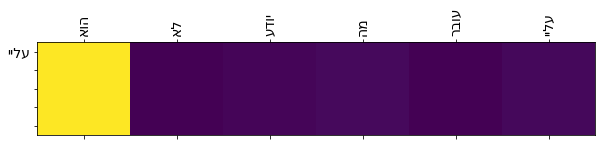

In [44]:
test_sentence = "הוא לא יודע מה עובר עליי"
result = tag(test_sentence)